In [1]:
import patch_config
import os
import numpy as np
from utils.general import non_max_suppression, xyxy2xywh
import torch
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from post_util import plot_boxes
import random
from load_data import InriaDataset, preds2boxes
from torch.utils.data import DataLoader
import shutil
from load_data import collate_fn
from pytorchyolo.models import Darknet

cfg = patch_config.patch_configs['yolov5s_dotast']()
model = cfg.model

/home/chanvo/miniconda3/envs/p11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fusing layers... 
YOLOv5s summary: 157 layers, 7069459 parameters, 0 gradients, 15.9 GFLOPs


In [5]:
d = cfg.val_img_dir
# save_dir = cfg.val_lab_dir
save_dir = os.path.join(d, '..', f'labels_{cfg.patch_name}')

In [6]:
clean_loader = DataLoader(InriaDataset(d, None, cfg.img_size, None), batch_size=24, shuffle=True,
                          collate_fn=collate_fn)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.mkdir(save_dir)

for imgs, _, _, (paths, _) in clean_loader:
    imgs = imgs.cuda()
    with torch.no_grad():
        out = model(imgs)
    bboxes = preds2boxes(cfg, out)
    plot_boxes(imgs[1], bboxes[1], class_names=cfg.class_names).save('test.jpg')
    for i, boxes in enumerate(bboxes):
        boxes = torch.cat((boxes[:, -1:], boxes[:, :4]), dim=1)
        lab_path = (save_dir + '/' + os.path.basename(paths[i])
                    .replace('.jpg', '.txt')
                    .replace('.png', '.txt')
                    .replace('.bmp', '.txt'))
        np.savetxt(lab_path, boxes.cpu().numpy(), fmt='%.6f')

Total images count: 258


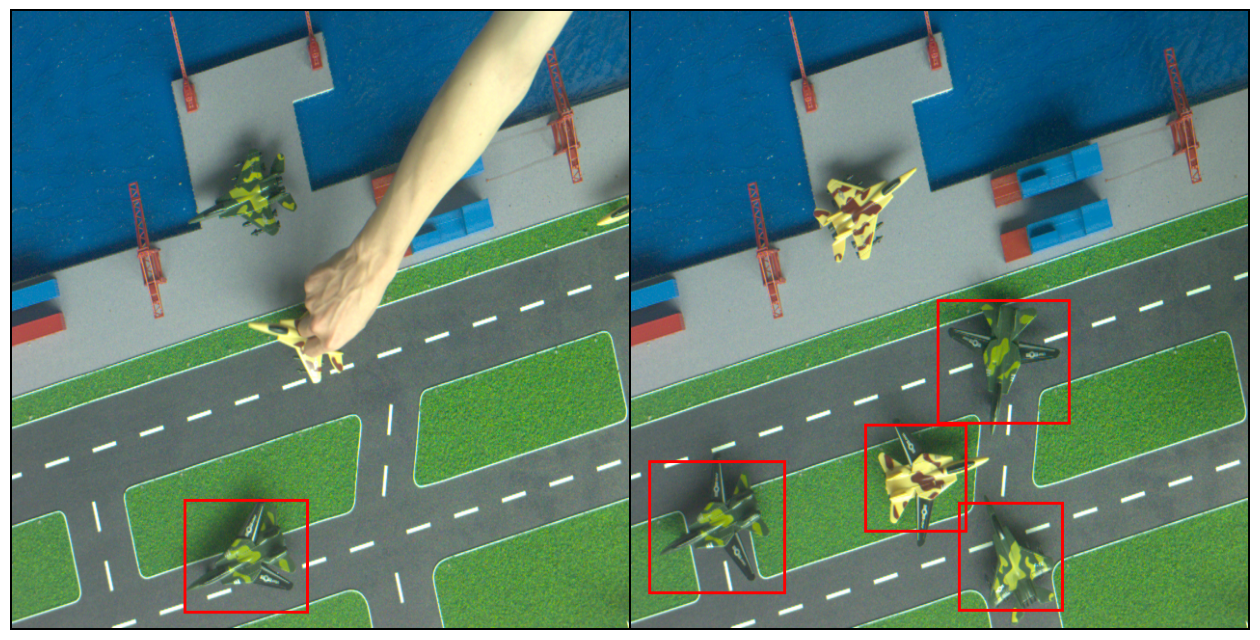

In [7]:
from torchvision.utils import make_grid
import torchvision.transforms as T
%matplotlib inline

loader = DataLoader(InriaDataset(d, save_dir, cfg.img_size, cfg.cls_id, pad=False), batch_size=2,
                    shuffle=True, collate_fn=collate_fn)
for bi, (imgs, labs, labs_idx, paths) in enumerate(loader):
    grids = []
    for i, img in enumerate(imgs):
        p = plot_boxes(img, labs[labs_idx == i, 1:], class_names=cfg.class_names)
        grids.append(np.array(p))
    grids = [torch.tensor(g, dtype=torch.float32).permute(2, 0, 1) / 255 for g in grids]
    grid_img = make_grid(grids, nrow=4).permute(1, 2, 0).numpy()
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(grid_img)
    plt.show()
    break